In [12]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *
import keras_cv
import keras_core as keras


BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE  # Ensure this is set for optimal parallel processing
tf.config.list_physical_devices('GPU')


Using TensorFlow backend


[]

# <span style="color:#e74c3c;"> </span> Preprocessing

In [13]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    
    # Check if the image was not read properly
    if img is None:
        raise FileNotFoundError(f"The image at path {img_path} was not found or cannot be read.")

    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')
    
    boxes = []
    classes = []
    
    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])
        
            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])
        
            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)
    
            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)
    
    return img_path, classes, boxes


# a function for creating file paths list 
def create_paths_list(path):
    full_path = []
    # Filter out files that are not images (such as .DS_Store)
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".txt"}  # Add more if needed
    images = [img for img in sorted(os.listdir(path)) if img.lower().endswith(tuple(valid_extensions))]
    
    for img in images:
        full_path.append(os.path.join(path, img))
        
    return full_path



class_ids = ['Acne']
class_mapping = {0: 'Acne'}

In [14]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):
    
    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)
    
    print(f"Found {len(img_files)} images and {len(annot_files)} annotations.")
    
    image_paths = []
    bbox = []
    classes = []
    
    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)
        
    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    
    return image_paths, classes, bbox

In [15]:
# applying functions
train_img_paths, train_classes, train_bboxes = creating_files('/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/data/Acne/train/images', 
                                                              '/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/data/Acne/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files('/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/data/Acne/valid/images',
                                                             '/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/data/Acne/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/data/Acne/test/images',
                                                          '/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/data/Acne/test/labels')

Found 204 images and 204 annotations.


Found 24 images and 24 annotations.
Found 21 images and 21 annotations.


# <span style="color:#e74c3c;"> Creating </span> Datasets

In [16]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32) 
    
    return img


resizing = keras_cv.layers.JitteredResize(
    target_size=(320, 320),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }
    
    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [32]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .cache()
                 .shuffle(BATCH_SIZE*100)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .cache()
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO)).cache()


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .cache()
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [18]:
# a function to visualize samples from a dataset

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 6,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

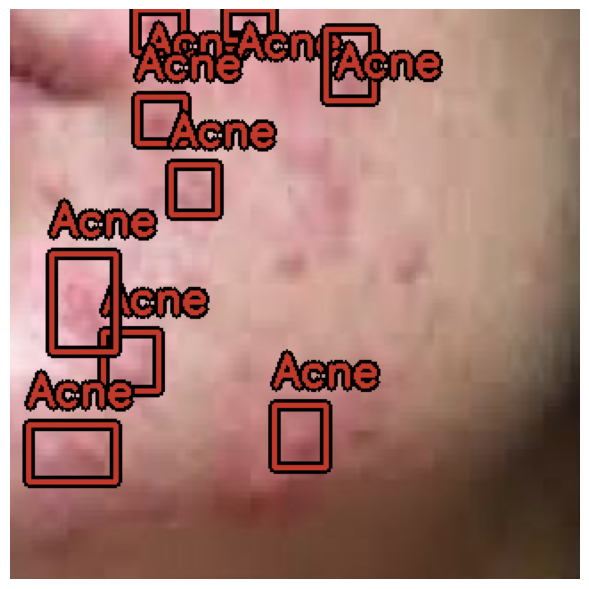

In [19]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1)

# <span style="color:#e74c3c;"> YOLO V8</span> Model

In [20]:
# creating mirrored strategy

stg = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [21]:
import keras_cv
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling = True)
    
    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                                  bounding_box_format = "xyxy", backbone = backbone, fpn_depth = 5)

    optimizer = AdamW(learning_rate=0.0007, weight_decay=0.0009, global_clipnorm = 10.0)
    my_callbacks = [ModelCheckpoint('src/checkpoints/yolo_acne_detection.weights.h5', monitor = 'val_loss',save_best_only = True, save_weights_only = True),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=8, verbose=0, min_delta=0.001),
                    EarlyStopping(monitor='val_loss', patience=10)]
    

    YOLOV8_model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')

# <span style="color:#e74c3c;"> Training </span> 

In [22]:
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,  epochs = 20, callbacks = my_callbacks)

Epoch 1/20


2024-03-09 15:29:14.167080: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


2/3 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 178.7868  

2024-03-09 15:31:42.013088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - loss: 176.4023 

2024-03-09 15:32:06.916279: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:32:17.805247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:32:17.805928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/suleymanismaylov/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 187s 27s/step - loss: 175.2101 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 2/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 143.0272

2024-03-09 15:33:06.342598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 146.5763 

2024-03-09 15:33:25.133103: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:33:25.197575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:33:25.198081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 66s 19s/step - loss: 148.3509 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 3/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 131.3482

2024-03-09 15:34:01.538638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 131.2597 

2024-03-09 15:34:15.792882: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:34:15.837878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:34:15.838477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 16s/step - loss: 131.2155 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 4/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 107.1290

2024-03-09 15:34:55.183481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 105.6069 

2024-03-09 15:35:10.252891: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:35:10.309166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:35:10.309769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 16s/step - loss: 104.8458 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 5/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 86.2289

2024-03-09 15:35:42.330643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 82.7955 

2024-03-09 15:35:56.054707: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:35:56.095922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:35:56.096317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 14s/step - loss: 81.0788 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 6/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 62.1952

2024-03-09 15:36:41.922939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 61.1955 

2024-03-09 15:36:57.806917: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:36:57.854712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:36:57.855289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 62s 18s/step - loss: 60.6957 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 7/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 55.9623

2024-03-09 15:37:44.300979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 55.2427 

2024-03-09 15:38:03.245264: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:38:03.299110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:38:03.299678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 19s/step - loss: 54.8829 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 8/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 16s 17s/step - loss: 57.7536 

2024-03-09 15:38:50.991679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 55.3183 

2024-03-09 15:39:06.865025: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:39:06.920633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:39:06.921849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 64s 17s/step - loss: 54.1006 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 9/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 17s 18s/step - loss: 45.1563

2024-03-09 15:39:49.759545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 45.4485 

2024-03-09 15:40:09.467972: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:40:09.553889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:40:09.555004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 63s 19s/step - loss: 45.5946 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-04
Epoch 10/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step - loss: 47.5703

2024-03-09 15:40:56.328533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 46.3223 

2024-03-09 15:41:11.388927: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:41:11.466842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:41:11.468062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 62s 17s/step - loss: 45.6983 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-06
Epoch 11/20
2/3 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 41.4401

2024-03-09 15:41:55.039573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 41.2696 

2024-03-09 15:42:08.861793: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-09 15:42:08.906153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:42:08.906811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 17s/step - loss: 41.1844 - val_loss: 0.0000e+00 - learning_rate: 7.0000e-06


# <span style="color:#e74c3c;"> Training </span> Results, Evaluation


Box loss not found in history
Box loss not found in history


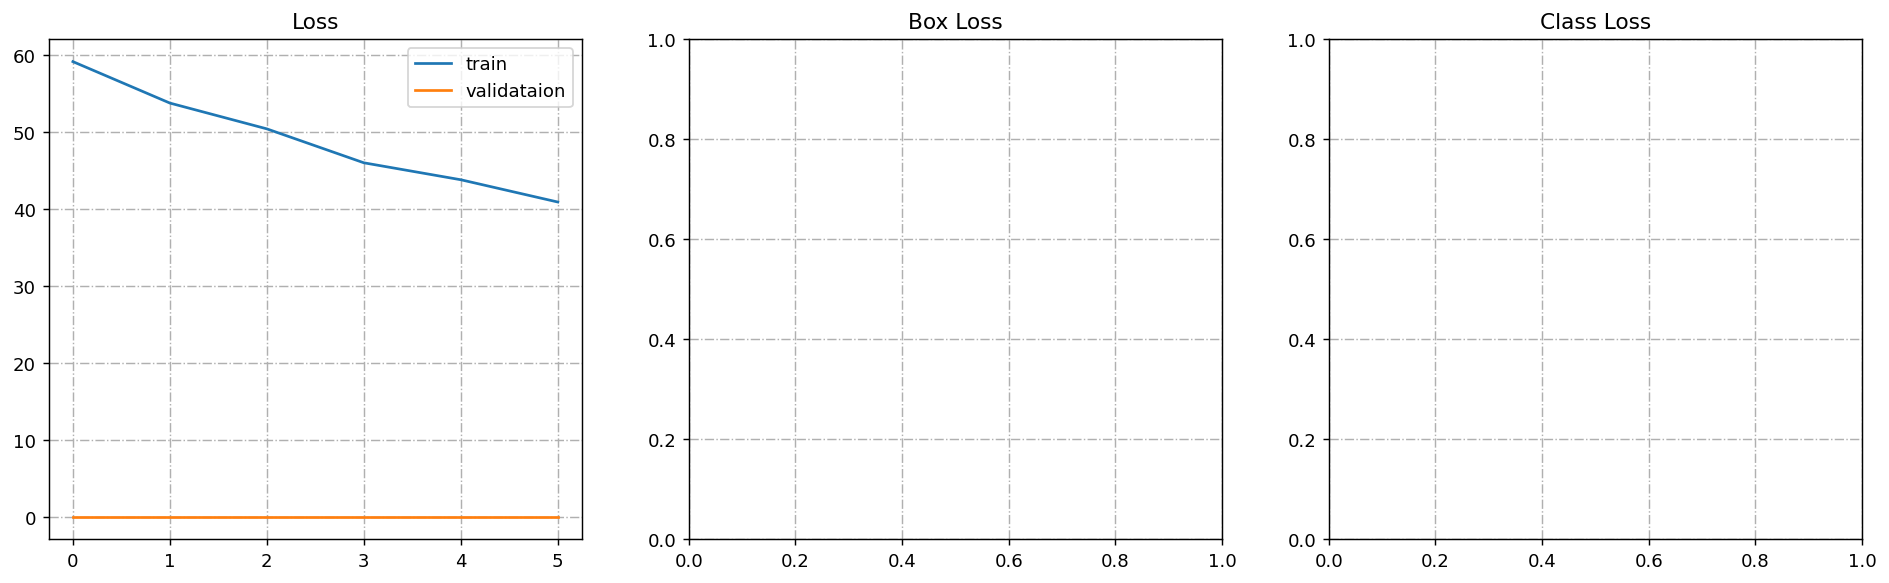

In [23]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][5:])
axs[0].plot(hist.history['val_loss'][5:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
if 'box_loss' in hist.history:
    axs[1].plot(hist.history['box_loss'])
    axs[1].plot(hist.history['val_box_loss'])
    axs[1].legend(["train", "validation"])
else:
    print("Box loss not found in history")


axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
if 'class_loss' in hist.history:
    axs[2].plot(hist.history['class_loss'])
    axs[2].plot(hist.history['val_class_loss'])
    axs[2].legend(["train", "validation"])
else:
    print("Box loss not found in history")

# <span style="color:#e74c3c;"> Test </span> Predictions

In [24]:
YOLOV8_model.evaluate(test_dataset)

2024-03-09 15:42:12.949489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-03-09 15:42:12.952515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


ValueError: math domain error

In [36]:
def visualize_predict_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))

    y_pred = model.predict(images, verbose = 0)
    ##y_pred = keras_cv.bounding_box.to_ragged(y_pred)
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping,
    )

Found 21 images and 21 annotations.


2024-03-09 15:48:18.196431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


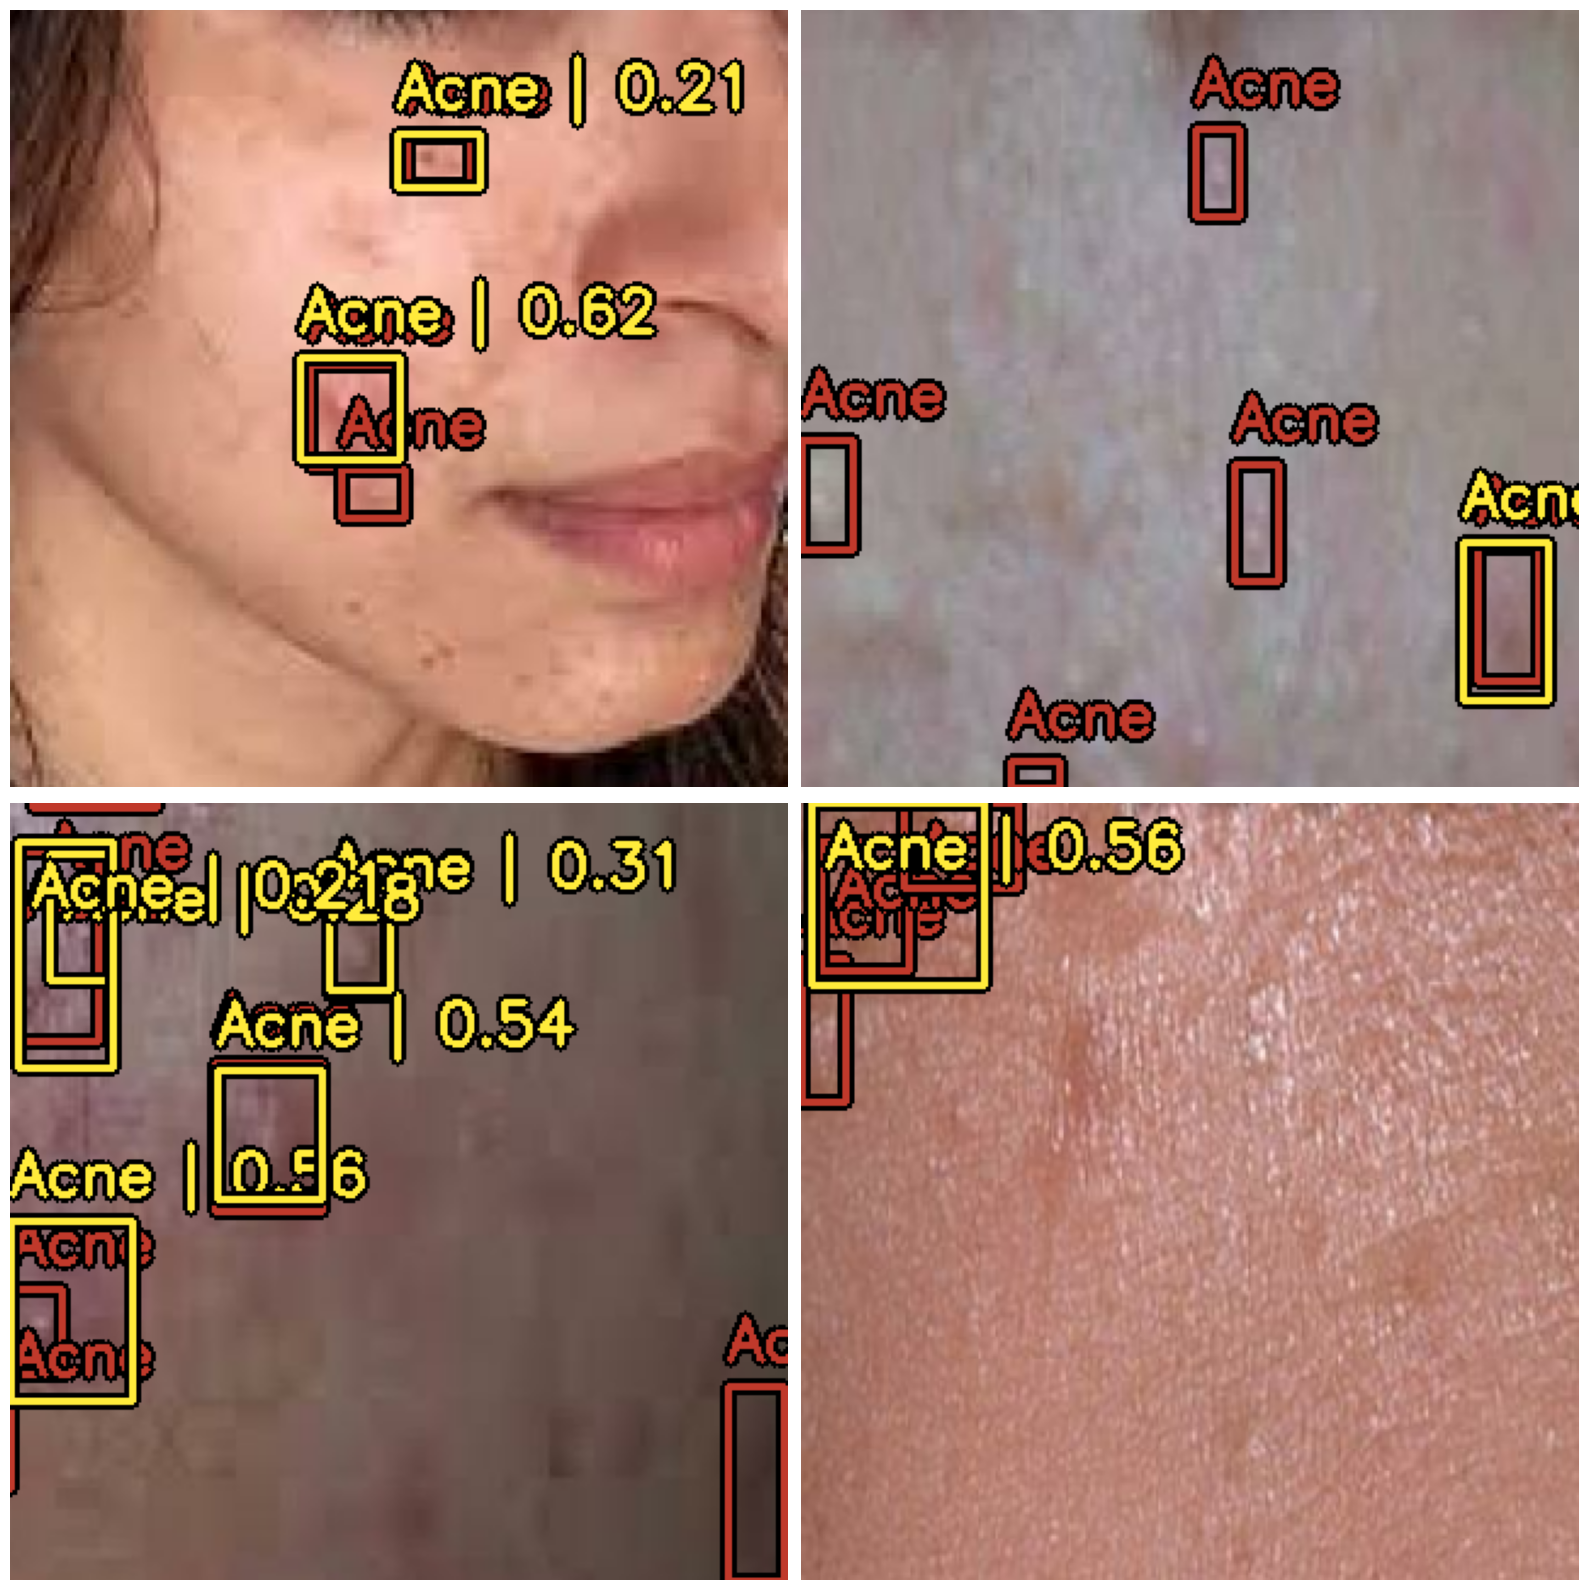

In [37]:

test_img_paths, test_classes, test_bboxes = creating_files('/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/data/Acne/test/images',
                                                          '/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/data/Acne/test/labels')

test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(16, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

# red -> ground true
# yellow -> prediction
# Check if the dataset is empty
if tf.data.experimental.cardinality(test_dataset).numpy() > 0:
    YOLOV8_model.load_weights('/Users/suleymanismaylov/Desktop/HolyHack-2024/Team_17/src/AModel/working/yolo_acne_detection.h5')
    visualize_predict_detections(YOLOV8_model, test_dataset, bounding_box_format="xyxy")
else:
    print("The dataset is empty. Please check your data loading and preprocessing steps.")
